<h1><center>STAT/CSE 416 Lab 2: Ridge and LASSO Regression</center></h1>
<center><b>Section:</b>AA/AB BA/BB</center>
<center><b>Instructor:</b>Emilija Perković</center>
<center><b>TA:</b>Octavian-Vlad Murad</center>
<center><b>Date:</b>January 19, 2023</center>

*Adapted from slides and notebooks from STAT/CSE 416 Spring 2021 TAs.*

## 1. Introduction

This lab will cover:
- Regularization by the $\ell_2$-penalty.
- Regularization by the $\ell_1$-penalty.
- Cross-validation to select hyperparameters.

## 2. Concepts

### 2.1. Why regularization?

**Regularization** generally refers to adjustment to the learning objective or optimization algorithm that will "smoothen" the resulting predictor $\hat{f}$ as an effort to **decrease variance** and **prevent overfitting**. (See [here](https://en.wikipedia.org/wiki/Overfitting) for examples.) 

A common framework for regularization involves decreasing the magnitude of the coefficients in the coefficient vector $w$. We use some measure $R(w)$ of the magnitude of the coefficients and add it to the training objective.
$$
\min_{w} \text{RSS}(w) + \lambda R(w).
$$
Note that these terms will often be in competition with one another; do we care more about fitting the data (keeping $\text{RSS}(w)$ small) or having small coefficients (keeping $R(w)$ small)? $\lambda$ controls this trade off.

**Exercise 2.1:**
- Does increasing $\lambda$ increase or decrease the values of the $w$ parameters? 
- What happens to $w$ when $\lambda \to 0$? 
- What happens to $w$ when $\lambda \to \infty$?
- What would we expect to happen if we set $\lambda < 0$?

### 2.2. Ridge vs Lasso

Ridge regression uses the $\ell_2$ penalty, that is
$$
R(w) = ||w||_2^2 = \sum_{j=1}^d |w_j|^2 = |w_1|^2 + ... + |w_d|^2.
$$
For those familiar with vector calculus or linear algebra, this is just the Euclidean length of $w$.
LASSO regression uses the $\ell_1$ penalty, that is
$$
R(w) = ||w||_1 = \sum_{j=1}^d |w_j| = |w_1| + ... + |w_d|.
$$

**Exercise 2.2:**
- In 2 dimensions, that is $w \in \mathbb{R}^2$, how does the set of $w$'s with $||w||_2 \leq 1$ look like? How does the function $f(w) = ||w||_2$ look like?
- In 2 dimensions, that is $w \in \mathbb{R}^2$, how does the set of $w$'s with $||w||_1 \leq 1$ look like? How does the function $f(w) = ||w||_1$ look like?

## 3. Preprocessing

The basic preprocessing steps will be viewing and standardizing the data.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
# Read in weather data and view.
weather = pd.read_csv("weather.csv")
weather.info()
weather.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   STA     20000 non-null  int64  
 1   YR      20000 non-null  int64  
 2   MO      20000 non-null  int64  
 3   DA      20000 non-null  int64  
 4   MAX     20000 non-null  float64
 5   MIN     20000 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 937.6 KB


,STA,YR,MO,DA,MAX,MIN
0,20501,45,5,5,86.0,75.0
1,10703,44,12,14,81.0,74.0
2,32805,42,12,29,72.0,45.0
3,32701,43,12,7,75.0,39.0
4,81601,45,3,9,89.0,76.0


In [5]:
# split the data into 75% train + validation and 25% test
train_data, test_data = train_test_split(weather, random_state=42, test_size=0.25)

# STA = Station, YR = Year, MO = Month, DA = Date, MIN = Min Temp in F, MAX = Max Temp in F.
# we are trying to predict MAX
input_cols = ['STA', 'YR', 'MO', 'DA', 'MIN']

train_X = train_data[input_cols]
train_y = train_data["MAX"]

test_X = test_data[input_cols]
test_y = test_data["MAX"]

**Exercise 3.1:**
- Which features do you expect to be the most relevant for this prediction task?

Check the shape of each set to make sure they make sense! Always a good test before performing any learning.

In [6]:
print("train input data shape:", train_X.shape)
print("train target data shape:", train_y.shape)
print()
print("test input data shape:", test_X.shape)
print("test target data shape:", test_y.shape)

train input data shape: (15000, 5)
train target data shape: (15000,)

test input data shape: (5000, 5)
test target data shape: (5000,)


**Exercise 3.2:** 
- Normalize the training and test set input data (`X`). To do this, use the [Standard Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) from sklearn.
- Explain how does standardization work?
- Why do we use standardization when using regularization? Would it make sense to use standardization when we're not using regularization?
- What statistics(mean, st. dev., variance) do we use to standardize the test data?

In [14]:
scaler = StandardScaler().fit(X=train_X)

train_X_norm = scaler.transform(X=train_X)
test_X_norm = scaler.transform(X=test_X)

## 4. Ridge Regression

We create a [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) linear model with a regularization coefficent of `1.0`. 

Note: This coefficent is referred to as "lambda ($\lambda$)" in course material and "alpha $\alpha$" in the `sklearn` docs. They are the same thing!

In [15]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

import numpy as np

import matplotlib.pyplot as plt

import matplotlib
font = {'size': 18}
matplotlib.rc('font', **font)

%matplotlib inline

Define a function `rmse(model, X, y_true)` that calculates the RMSE error for a given trained model, input, and target data.

In [12]:
def rmse(model, X, y_true):
    y_pred = model.predict(X=X)
    return mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)

**Exercise 4.1:** 
- Train the model using the training data and output the training and testing error.
- Why is it that the training error is usually lower than the testing error?

In [17]:
ridge_model = Ridge(alpha=1.0) # create a model
ridge_model.fit(X=train_X_norm, y=train_y) # put dataset into the model

print(f"Train Error: {rmse(model=ridge_model, X=train_X_norm, y_true=train_y)}")
print(f"Test Error: {rmse(model=ridge_model, X=test_X_norm, y_true=test_y)}")

Train Error: 7.09626803158672
Test Error: 7.217888426067041


**Exercise 4.2:** 
- Perform 5-fold cross validation with your Ridge model. Output the array of errors (length 5) as well as the mean error. You should use [Cross Validation Score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html?highlight=cross_val_scor) from `sklearn` to do this.
- Explain what you think happens inside the sklearn function.

In [19]:
ridge_CV_scores = cross_val_score(estimator=Ridge(alpha=1.0), X=train_X_norm, y=train_y, cv=5, scoring=rmse)
# score: the function that use to evaluate efficiency
print(f"All folds errors: {ridge_CV_scores}")
print(f"Mean error: {ridge_CV_scores.mean()}")

All folds errors: [7.13751613 7.05213671 7.06632828 7.02454875 7.2210618 ]
Mean error: 7.100318333394048


**Exercise 4.3:**
- Perform 5-fold cross validation on Ridge models with a range of `alpha` values. For each `alpha`, store the `alpha` value, the validation error, and the training error into a dictionary. Create a list of dictionaries, corresponding to each value of `alpha`. Convert this into a `pd.DataFrame`.

In [20]:
data = []

for alpha in np.logspace(1, 7, num=25):
    # alpha = lambda in the Ridge expression
    ridge_model = Ridge(alpha=alpha)
    
    # perform cross validation
    ridge_CV_scores = cross_val_score(estimator=ridge_model, X=train_X_norm, y=train_y, cv=5, scoring=rmse)
    
    # compute mean error
    val_error = ridge_CV_scores.mean()
    
    ridge_model.fit(X=train_X_norm, y=train_y)
    train_error = rmse(model=ridge_model, X=train_X_norm, y_true=train_y)
    
    data.append(dict(alpha=np.format_float_scientific(alpha, precision=0), 
                     val_error=val_error, 
                     train_error=train_error))
    
data = pd.DataFrame(data)
data

,alpha,val_error,train_error
0,1.e+01,7.100327,7.096273
1,2.e+01,7.100345,7.096285
2,3.e+01,7.100402,7.096321
3,6.e+01,7.100581,7.096435
4,1.e+02,7.101140,7.096794
5,2.e+02,7.102880,7.097915
6,3.e+02,7.108225,7.101379
7,6.e+02,7.124296,7.111903
8,1.e+03,7.170793,7.142897
9,2.e+03,7.296597,7.229353


Now we will display the error curves as well as pick the best value of alpha and compute its error on the test set.

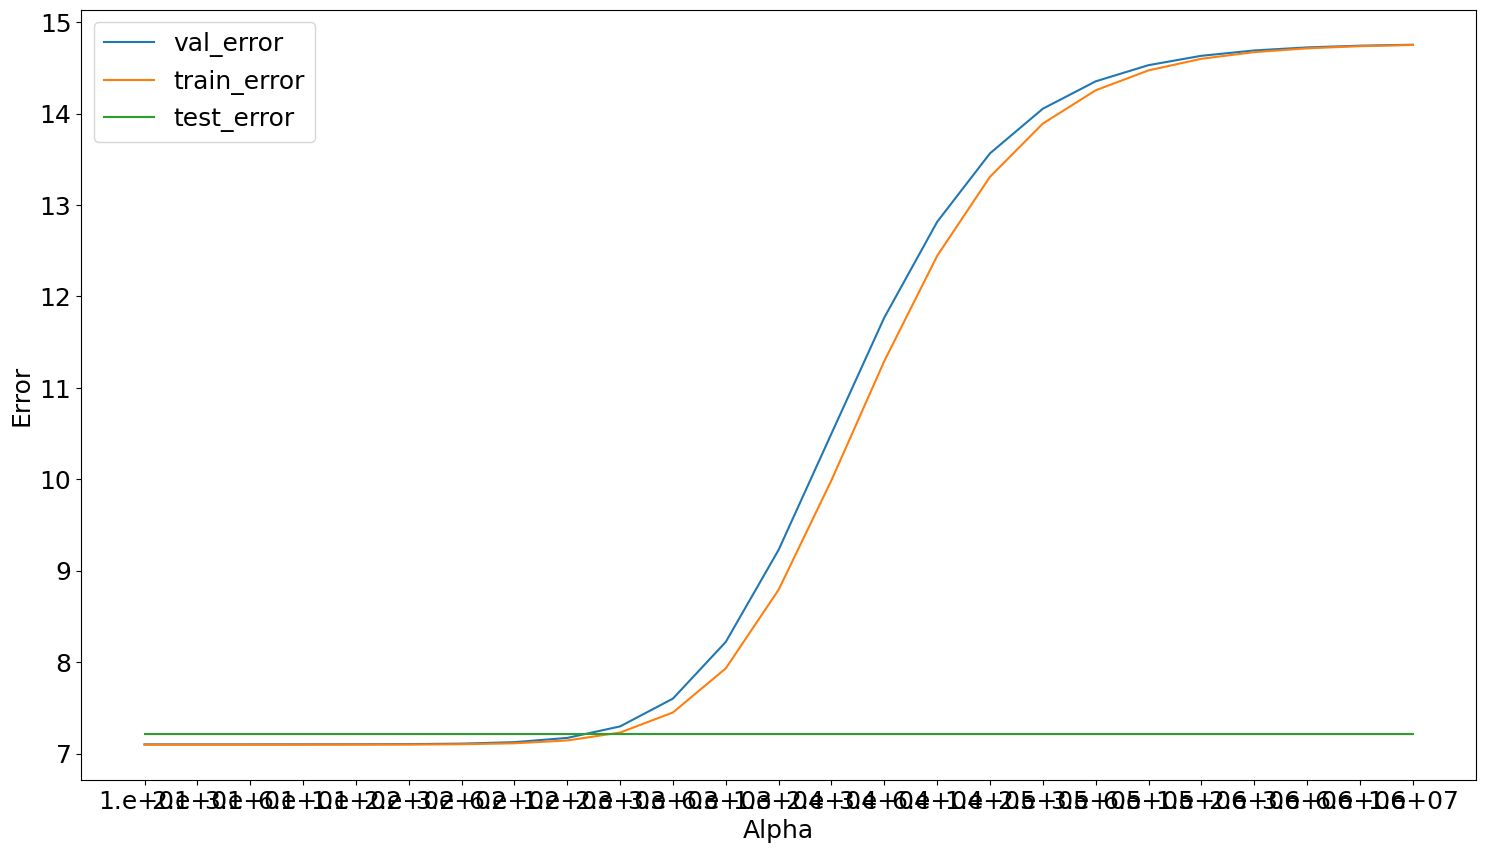

In [21]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X=train_X_norm, y=train_y)

test_error = rmse(model=ridge_model, X=test_X_norm, y_true=test_y)
test_error = np.repeat(test_error, data.shape[0])

plt.figure(figsize=(18, 10))

plt.plot(data["alpha"].to_numpy(), data["val_error"].to_numpy(), label="val_error")
plt.plot(data["alpha"].to_numpy(), data["train_error"].to_numpy(), label="train_error")
plt.plot(data["alpha"].to_numpy(), test_error, label="test_error")

plt.legend()
plt.xlabel("Alpha")
plt.ylabel("Error")

plt.show()

**Exercise 4.4:**
- In the plot above which direction on the x-axis corresponds to more complex models?
- Would you say the models we trained are overfitting, underfitting, or neither?

We can see that alpha decreases on the left -> complexity increases from right to left, and we can see that value error does not dramatically decreases lower than 7 -> may not be the optimal model for this type of problem.

Now we will take a look at how the weights of Ridge models change as you change the regularization coefficient!

In [22]:
data = []

for alpha in np.logspace(1, 7, num=25):
    
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X=train_X_norm, y=train_y)
    
    new_datum = dict(alpha=np.format_float_scientific(alpha, precision=0), 
                     w_0=ridge_model.intercept_)
    # enumerate(, 1): start with the 2nd iteration instead (counter=1, skip the intercept constant coeff[0])
    new_datum.update({f"w_{i}": coef for i, coef in enumerate(ridge_model.coef_, 1)})
    
    data.append(new_datum)
    
data = pd.DataFrame(data)
# coefficents goes to zero as alpha/lambda increases
data             

,alpha,w_0,w_1,w_2,w_3,w_4,w_5
0,1.e+01,80.9786,0.486129,0.764300,-0.415440,0.065493,12.930585
1,2.e+01,80.9786,0.486313,0.763609,-0.414979,0.065374,12.923816
2,3.e+01,80.9786,0.486640,0.762383,-0.414163,0.065165,12.911796
3,6.e+01,80.9786,0.487215,0.760210,-0.412715,0.064793,12.890477
4,1.e+02,80.9786,0.488221,0.756373,-0.410159,0.064138,12.852741
5,2.e+02,80.9786,0.489958,0.749629,-0.405666,0.062990,12.786182
6,3.e+02,80.9786,0.492886,0.737886,-0.397839,0.061001,12.669521
7,6.e+02,80.9786,0.497613,0.717761,-0.384418,0.057618,12.467277
8,1.e+03,80.9786,0.504639,0.684199,-0.362025,0.052058,12.123245
9,2.e+03,80.9786,0.513448,0.630735,-0.326359,0.043429,11.556440


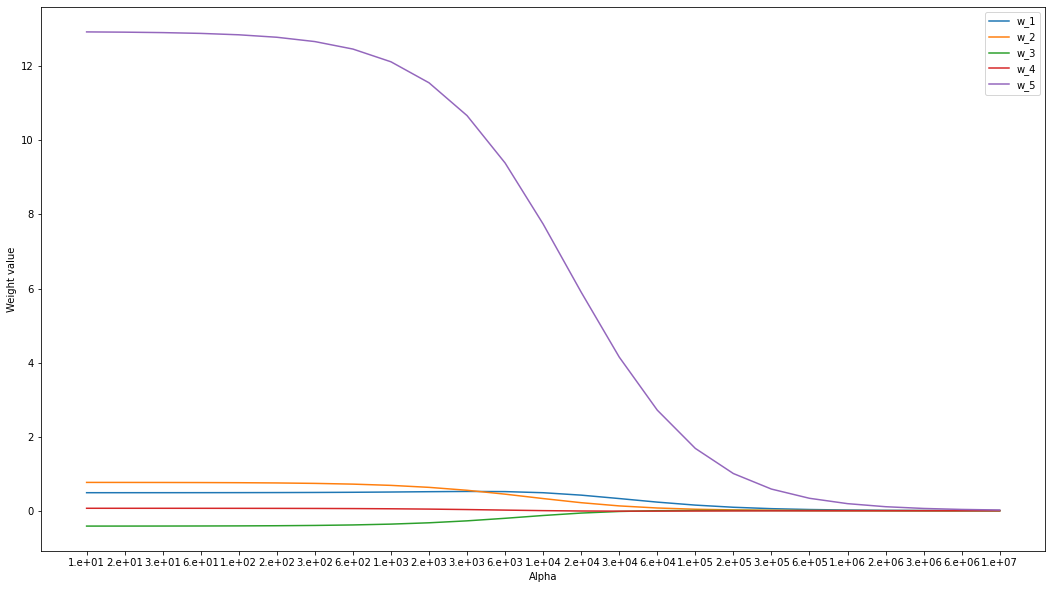

In [13]:
plt.figure(figsize=(18, 10))

for i in range(1, 6):
    label = "w_" + str(i)
    plt.plot(data["alpha"].to_numpy(), data[label].to_numpy(), label=label)

plt.legend()
plt.xlabel("Alpha")
plt.ylabel("Weight value")

plt.show()

**Exercise 4.5:**
- How do the coefficient paths differ between Ridge models and Lasso models?
- Which features would you say are the most relevant for our prediction?
- Why is w_0 so large compared to the other values? What does w_0 represent and how is it computed?

# 5. Regularization with LASSO

Create a [LASSO](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) linear model with a regularization coefficent of `1.0`.

In [14]:
from sklearn.linear_model import Lasso

In [15]:
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X=train_X_norm, y=train_y)

print(f"Train Error: {rmse(model=lasso_model, X=train_X_norm, y_true=train_y)}")
print(f"Test Error: {rmse(model=lasso_model, X=test_X_norm, y_true=test_y)}")

Train Error: 7.248086829452871
Test Error: 7.359095968361762


Perform 5-fold cross validation with your LASSO model. Output the array of errors (length 5) as well as the mean error.

In [16]:
lasso_CV_scores = cross_val_score(estimator=Lasso(alpha=1.0), X=train_X_norm, y=train_y, cv=5, scoring=rmse)
print(f"All folds errors: {lasso_CV_scores}")
print(f"Mean error: {lasso_CV_scores.mean()}")

All folds errors: [7.33292324 7.23192583 7.17571535 7.17102864 7.33554848]
Mean error: 7.249428309445422


Perform 5-fold cross validation with your Ridge model. Output the array of errors (length 5) as well as the mean error. You should use [Cross Validation Score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html?highlight=cross_val_scor) from `sklearn` to do this.

In [17]:
data = []

for alpha in np.logspace(-2, 2, num=25):
    
    lasso_model = Lasso(alpha=alpha)
    lasso_CV_scores = cross_val_score(estimator=lasso_model, X=train_X_norm, y=train_y, cv=5, scoring=rmse)
    val_error = lasso_CV_scores.mean()
    
    lasso_model.fit(X=train_X_norm, y=train_y)
    train_error = rmse(model=lasso_model, X=train_X_norm, y_true=train_y)
    
    data.append(dict(alpha=np.format_float_scientific(alpha, precision=0), 
                     train_error=train_error,
                     val_error=val_error))
    
data = pd.DataFrame(data)
data

,alpha,train_error,val_error
0,1.e-02,7.096301,7.100359
1,1.e-02,7.096339,7.100401
2,2.e-02,7.096422,7.100489
3,3.e-02,7.096599,7.100657
4,5.e-02,7.096981,7.100958
5,7.e-02,7.097761,7.101603
6,1.e-01,7.099135,7.102949
7,1.e-01,7.102093,7.105948
8,2.e-01,7.108462,7.112377
9,3.e-01,7.122164,7.126164


Now we will display the error curves as well as pick the best value of alpha and compute its error on the test set.

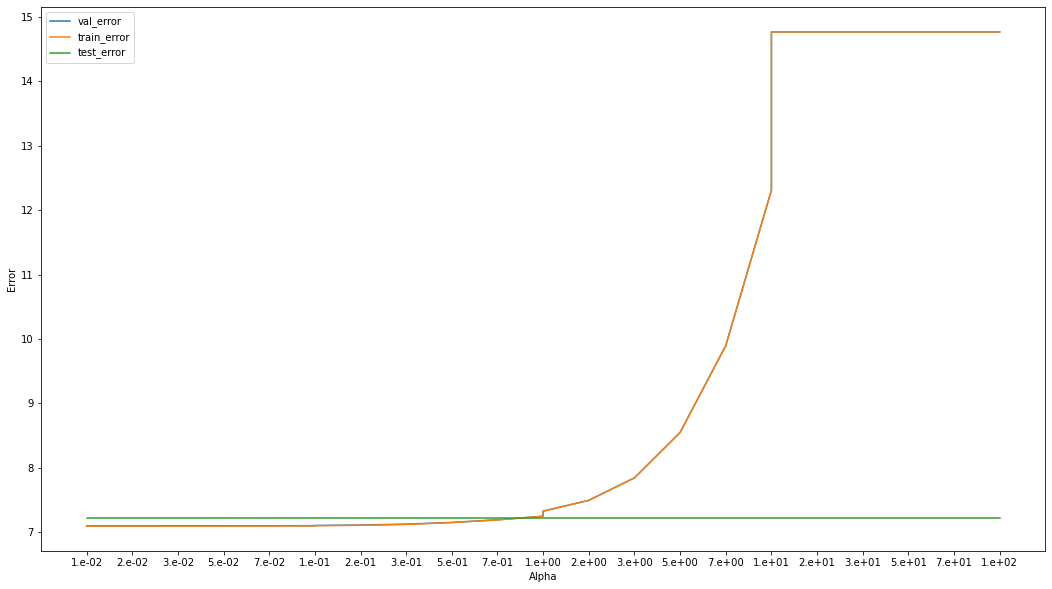

In [18]:
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X=train_X_norm, y=train_y)

test_error = rmse(model=lasso_model, X=test_X_norm, y_true=test_y)
test_error = np.repeat(test_error, data.shape[0])

plt.figure(figsize=(18, 10))

plt.plot(data["alpha"].to_numpy(), data["val_error"].to_numpy(), label="val_error")
plt.plot(data["alpha"].to_numpy(), data["train_error"].to_numpy(), label="train_error")
plt.plot(data["alpha"].to_numpy(), test_error, label="test_error")

plt.legend()
plt.xlabel("Alpha")
plt.ylabel("Error")

plt.show()

Take a look at how the weights of LASSO models change as you change the regularization coefficient! For reasons we might not delve into in this course, LASSO tends to find **sparse** solutions, i.e. solutions that have many zeros in the coefficient vector.

In [19]:
data = []

for alpha in np.logspace(-2, 2, num=25):
    
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X=train_X_norm, y=train_y)
    
    new_datum = dict(alpha=np.format_float_scientific(alpha, precision=0), w_0=lasso_model.intercept_)
    new_datum.update({f"w_{i}": coef for i, coef in enumerate(lasso_model.coef_, 1)})
    data.append(new_datum)
    
data = pd.DataFrame(data)
data 

,alpha,w_0,w_1,w_2,w_3,w_4,w_5
0,1.e-02,80.9786,0.477517,0.756879,-0.406577,0.055353,12.928735
1,1.e-02,80.9786,0.473608,0.752990,-0.402154,0.050538,12.923795
2,2.e-02,80.9786,0.467872,0.747282,-0.395661,0.043471,12.916544
3,3.e-02,80.9786,0.459452,0.738903,-0.386131,0.033098,12.905901
4,5.e-02,80.9786,0.447093,0.726604,-0.372143,0.017872,12.890280
5,7.e-02,80.9786,0.428924,0.708610,-0.351658,0.000000,12.867404
6,1.e-01,80.9786,0.402091,0.682537,-0.321865,0.000000,12.834133
7,1.e-01,80.9786,0.362704,0.644266,-0.278135,0.000000,12.785299
8,2.e-01,80.9786,0.304892,0.588093,-0.213948,0.000000,12.713621
9,3.e-01,80.9786,0.219978,0.505683,-0.119730,0.000000,12.608416


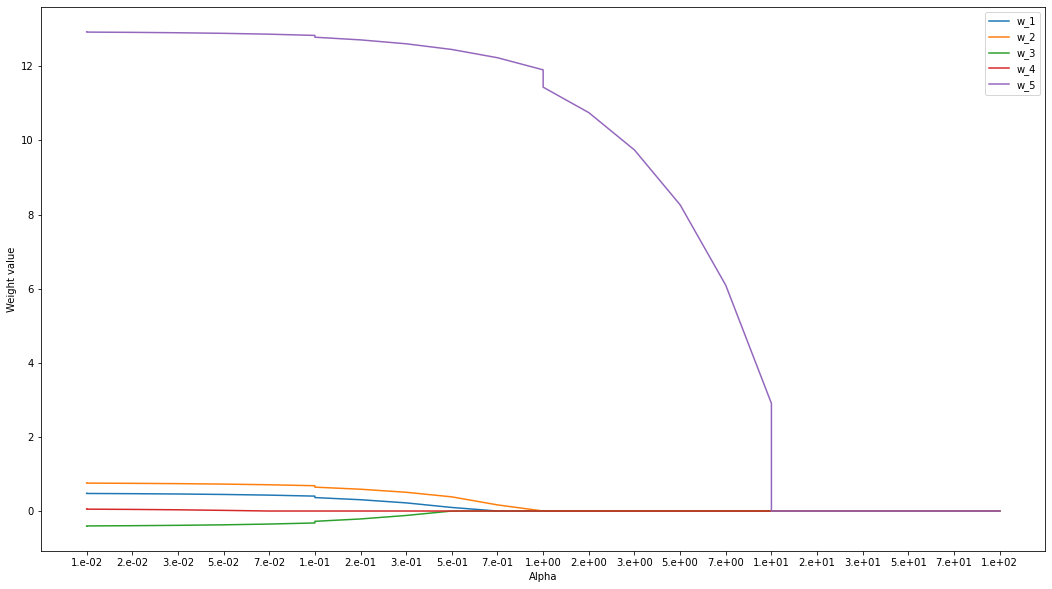

In [20]:
plt.figure(figsize=(18, 10))

for i in range(1, 6):
    label = "w_" + str(i)
    plt.plot(data["alpha"].to_numpy(), data[label].to_numpy(), label=label)

plt.legend()
plt.xlabel("Alpha")
plt.ylabel("Weight value")

plt.show()